In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import evaluate
from huggingface_hub import create_repo
import warnings
import re
import torch
warnings.filterwarnings("ignore")

In [71]:
## Load the Credit Card Customer Data from Hugging Face Datasets
customer_data = pd.DataFrame(load_dataset("ModSpecialization/Credit_Card_Customer_Data", split="train"))
terminal_data = pd.DataFrame(load_dataset("ModSpecialization/Credit_Card_Terminal_Dataset", split="train"))
customer_termimnal_data = pd.DataFrame(load_dataset("ModSpecialization/Customer_Terminal_Dataset", split="train"))
credit_card_transaction_data = pd.DataFrame(load_dataset("ModSpecialization/Credit_Card_Transaction_Dataset", split="train"))

In [73]:

# Replace spaces with underscores in all DataFrame column names
customer_data.columns = customer_data.columns.str.replace(r"\s+", '_', regex=True)
terminal_data.columns = terminal_data.columns.str.replace(r"\s+", '_', regex=True)
customer_termimnal_data.columns = customer_termimnal_data.columns.str.replace(r"\s+", '_', regex=True)
credit_card_transaction_data.columns = credit_card_transaction_data.columns.str.replace(r"\s+", '_', regex=True)

# customer_data.to_csv("customer_data.csv", index=False)
# terminal_data.to_csv("terminal_data.csv", index=False)
# customer_termimnal_data.to_csv("customer_terminal_data.csv", index=False)
# credit_card_transaction_data.to_csv("credit_card_transaction_data.csv", index=False)

## Merge the datasets for training and test dataset
merged_dataset = credit_card_transaction_data \
    .merge(customer_data, on="Customer_Id", how="left") \
    .merge(terminal_data, on="Terminal_Id", how="left") \
    .merge(customer_termimnal_data, on=["Customer_Id", "Terminal_Id"], how="left") \
    .sample(n=len(credit_card_transaction_data), random_state=42)

# Rename columns to avoid conflicts
merged_dataset = merged_dataset.rename(columns={
    'Transaction_Amount_($)': 'Transaction_Amount'
})

# Reset the index of the merged dataset
merged_dataset = merged_dataset.reset_index(drop=True)

# merged_dataset.to_csv("merged_credit_card_data.csv", index=False)


print(merged_dataset.info())
print(merged_dataset.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Customer_Id                           7400 non-null   object 
 1   Terminal_Id                           7400 non-null   object 
 2   Transaction_Amount                    7400 non-null   float64
 3   Transaction_Time                      7400 non-null   object 
 4   Is_Fraud                              7400 non-null   object 
 5   Fraud_Reason                          2118 non-null   object 
 6   Avg_transaction_pattern               7400 non-null   int64  
 7   CardholderAge                         7400 non-null   int64  
 8   Gender                                7400 non-null   object 
 9   Transaction_Alert_Configuration       7400 non-null   int64  
 10  Location_x                            7400 non-null   int64  
 11  TimeOfDay        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7400 entries, 0 to 7399
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Terminal_Id                      7400 non-null   object 
 1   Transaction_Amount               7400 non-null   float64
 2   Transaction_Time                 7400 non-null   object 
 3   Is_Fraud                         7400 non-null   object 
 4   Avg_transaction_pattern          7400 non-null   int64  
 5   CardholderAge                    7400 non-null   int64  
 6   Gender                           7400 non-null   object 
 7   Transaction_Alert_Configuration  7400 non-null   int64  
 8   Location_x                       7400 non-null   int64  
 9   TimeOfDay                        7400 non-null   object 
 10  Merchant_Type                    7400 non-null   object 
 11  Store_Types                      7400 non-null   object 
 12  Location_y          

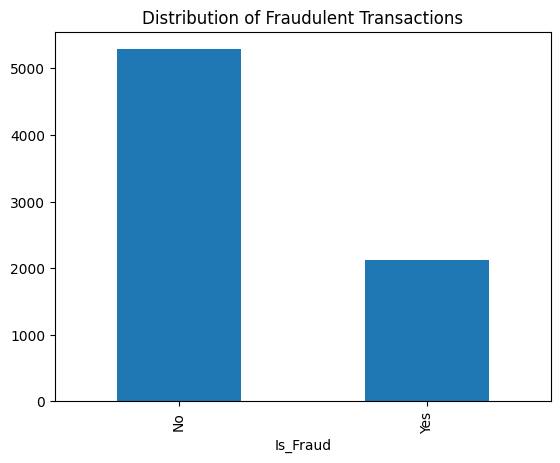

In [74]:
# Remove unnecessary columns
columns_to_drop = ['Customer_Id', 'Fraud_Reason', 'Customer_Location', 'Terminal_Location', 'Customer_Gender',
                   'Terminal_Gender_Profile_y', 'Avg_Customer_Transaction_Pattern_($)', 'Avg_Terminal_Transaction_Pattern_($)']

merged_dataset = merged_dataset.drop(columns=columns_to_drop)
print(merged_dataset.info())

features = merged_dataset.columns[merged_dataset.columns != 'Is_Fraud']
target = 'Is_Fraud'

X = merged_dataset[features]
y = merged_dataset[target]

y.value_counts().plot(kind='bar', title='Distribution of Fraudulent Transactions')

print(X.columns)


In [75]:
# Concatenate X and y for easier manipulation
df = pd.concat([X, y], axis=1)

# Separate majority and minority classes
majority_class = df[df['Is_Fraud'] == 'No']
minority_class = df[df['Is_Fraud'] == 'Yes']

# Downsample majority class
majority_downsampled = resample(
    majority_class,
    replace=False,  # sample without replacement
    n_samples=len(minority_class),  # match minority class
    random_state=42
)

# Combine minority class with downsampled majority class
df_balanced = pd.concat([majority_downsampled, minority_class])

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target again
X_balanced = df_balanced.drop('Is_Fraud', axis=1)
y_balanced = df_balanced['Is_Fraud']

print(y_balanced.value_counts())

Is_Fraud
Yes    2118
No     2118
Name: count, dtype: int64


## Training parameters
` The success of your fine-tuning depends heavily on choosing the right training parameters. - Hugging Face `

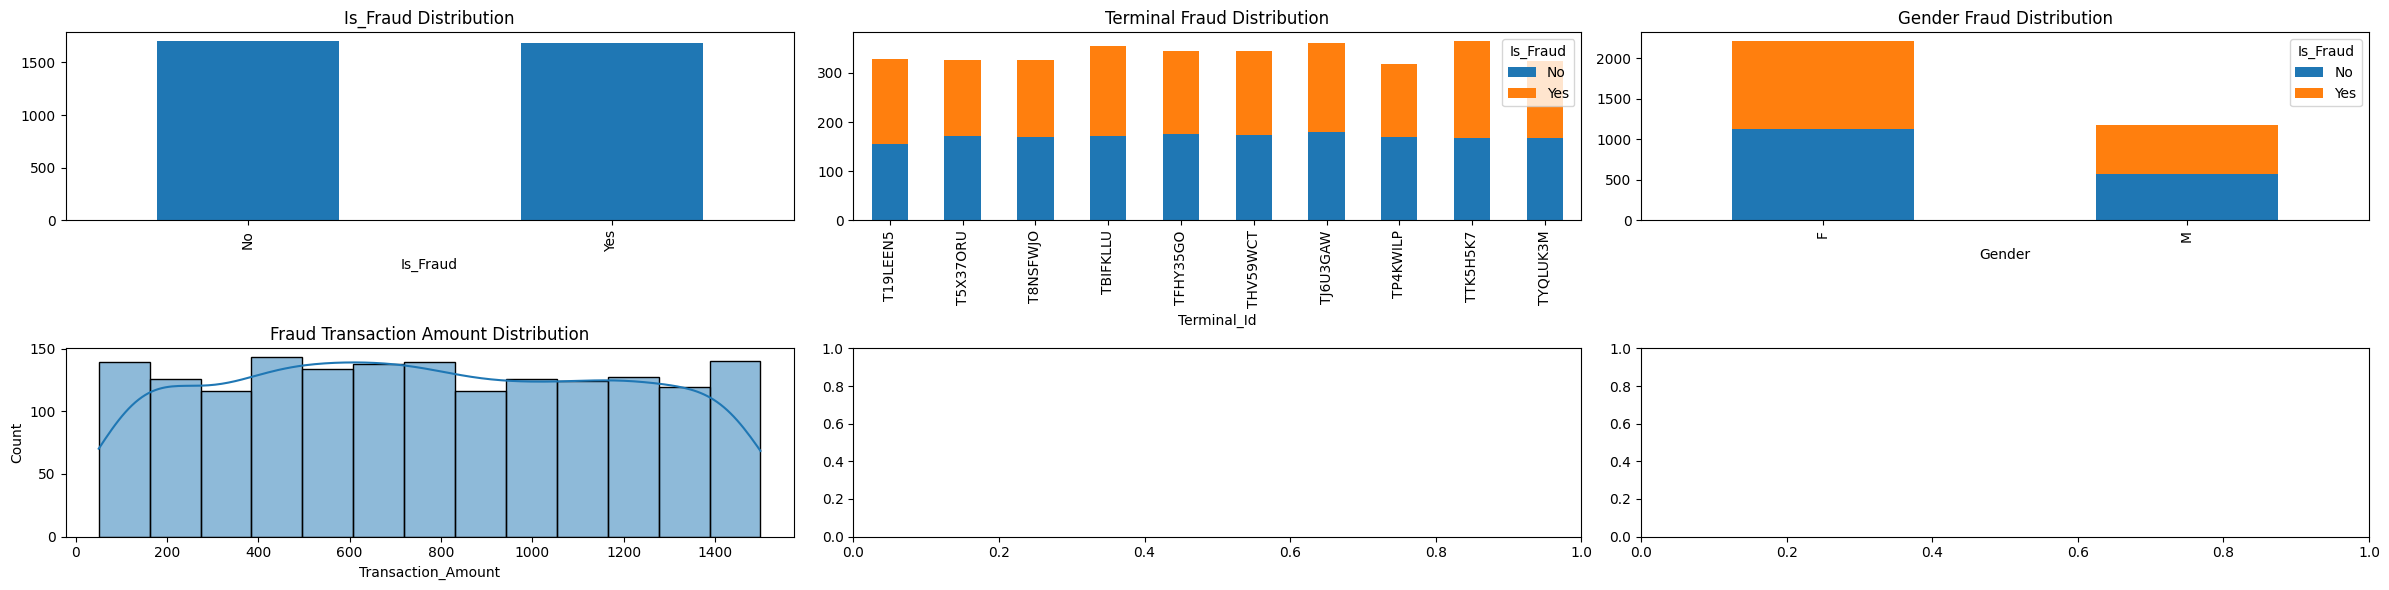

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
training_dataset = pd.concat([X_train, y_train], axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)


fig, axes = plt.subplots(2, 3, figsize=(24, 6))

training_dataset['Is_Fraud'].value_counts().plot.bar(ax = axes[0, 0], title='Is_Fraud Distribution')

pd.crosstab(training_dataset['Terminal_Id'], training_dataset['Is_Fraud']) \
    .plot(kind='bar', stacked=True, title='Terminal Fraud Distribution', ax=axes[0, 1])

pd.crosstab(training_dataset['Gender'], training_dataset['Is_Fraud']) \
    .plot(kind='bar', stacked=True, title='Gender Fraud Distribution', ax=axes[0, 2])

fraud_data = training_dataset[training_dataset['Is_Fraud'] == 'Yes']
sns.histplot(fraud_data['Transaction_Amount'], ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Fraud Transaction Amount Distribution')

plt.tight_layout()
plt.show()

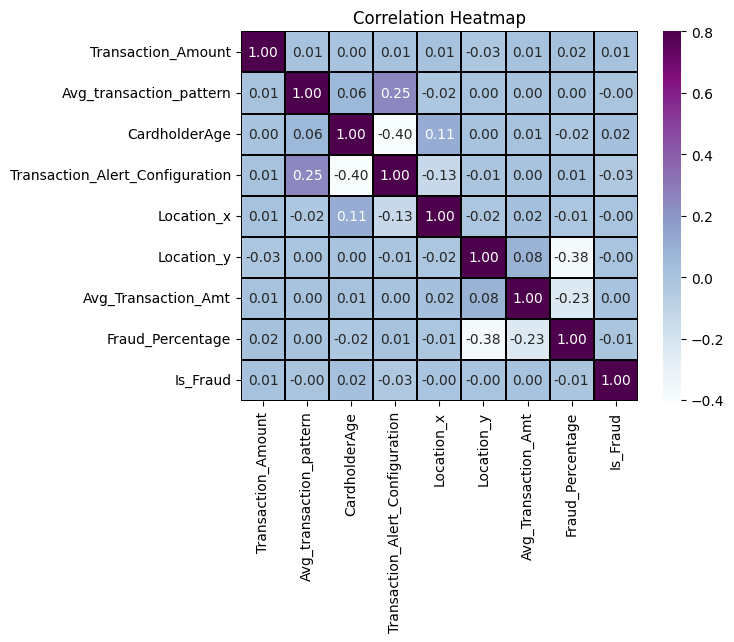

In [77]:
data_for_heatmap = training_dataset.select_dtypes(include=[np.number]).copy()
data_for_heatmap['Is_Fraud'] = training_dataset['Is_Fraud'].apply(lambda x: 1 if x == 'Yes' else 0)
matrix = data_for_heatmap.corr()
sns.heatmap(matrix, annot=True, fmt=".2f", vmax=".8", cmap='BuPu', linewidths=0.1, linecolor='black')
plt.title('Correlation Heatmap')
plt.show()


In [78]:
print(training_dataset['Is_Fraud'].value_counts())



Is_Fraud
No     1701
Yes    1687
Name: count, dtype: int64


In [79]:
## Define the feature columns and create text features for the model
feature_columns = ['Terminal_Id', 'Transaction_Amount', 'Transaction_Time',
       'Avg_transaction_pattern', 'CardholderAge', 'Gender',
       'Transaction_Alert_Configuration', 'Location_x', 'TimeOfDay',
       'Merchant_Type', 'Store_Types', 'Location_y', 'Avg_Transaction_Amt',
       'Terminal_Gender_Profile_x', 'Fraud_Percentage', 'Is_Fraud']

# Convert all categorical columns to numeric codes
for col in training_dataset.select_dtypes(include=['object', 'category']).columns:
    if col != 'Is_Fraud':  # Exclude target if needed
        training_dataset[col] = training_dataset[col].astype('category').cat.codes
        test_dataset[col] = test_dataset[col].astype('category').cat.codes

print(training_dataset.info())

def create_text_features(row):
    features = [f"{col}: {row[col]:.4f}" for col in feature_columns if col not in ["Is_Fraud"]]
    return " | ".join(features)

training_dataset["text"] = training_dataset.apply(create_text_features, axis=1)
test_dataset["text"] = test_dataset.apply(create_text_features, axis=1)

# Encode the labels
label_encoder = LabelEncoder()
training_dataset = training_dataset.dropna(subset=['Is_Fraud'])
training_dataset['label'] = label_encoder.fit_transform(training_dataset['Is_Fraud']).astype(int) # 0 for 'No', 1 for 'Yes'
test_dataset['label'] = label_encoder.fit_transform(test_dataset['Is_Fraud']).astype(int) # 0 for 'No', 1 for 'Yes'

print(training_dataset.head())
# Display the distribution of labels in the training dataset
print(test_dataset.head())

# Convert the DataFrame to a Distilbert dataset
train_model_dataset = Dataset.from_pandas(training_dataset[["text", "label"]])
test_model_dataset = Dataset.from_pandas(test_dataset[["text"]])

print(train_model_dataset)


<class 'pandas.core.frame.DataFrame'>
Index: 3388 entries, 3252 to 860
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Terminal_Id                      3388 non-null   int8   
 1   Transaction_Amount               3388 non-null   float64
 2   Transaction_Time                 3388 non-null   int8   
 3   Avg_transaction_pattern          3388 non-null   int64  
 4   CardholderAge                    3388 non-null   int64  
 5   Gender                           3388 non-null   int8   
 6   Transaction_Alert_Configuration  3388 non-null   int64  
 7   Location_x                       3388 non-null   int64  
 8   TimeOfDay                        3388 non-null   int8   
 9   Merchant_Type                    3388 non-null   int8   
 10  Store_Types                      3388 non-null   int8   
 11  Location_y                       3388 non-null   int64  
 12  Avg_Transaction_Amt    

In [80]:
# Load the DistilBERT tokenizer and model
PRE_TRAINED_MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# Tokenize the datasets
train_model_dataset = train_model_dataset.map(tokenize_function, batched=True).shuffle()
test_model_dataset = test_model_dataset.map(tokenize_function, batched=True).shuffle()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/3388 [00:00<?, ? examples/s]

Map:   0%|          | 0/848 [00:00<?, ? examples/s]

In [81]:
# Evaluation metrics
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels)["precision"],
        "recall": recall.compute(predictions=preds, references=labels)["recall"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"],
    }

# Training args
training_args = TrainingArguments(
    output_dir="./fraud_output",
    eval_strategy="epoch"
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_model_dataset,
    eval_dataset=test_model_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [82]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,No log
2,0.701400,No log
3,0.695900,No log


TrainOutput(global_step=1272, training_loss=0.6976576271297047, metrics={'train_runtime': 740.6469, 'train_samples_per_second': 13.723, 'train_steps_per_second': 1.717, 'total_flos': 1346398639939584.0, 'train_loss': 0.6976576271297047, 'epoch': 3.0})

In [83]:
import json
# Evaluate on train set (optional full report)
train_preds = trainer.predict(train_model_dataset)
pred_labels = np.argmax(train_preds.predictions, axis=1)
true_labels = train_model_dataset["label"]
report = classification_report(true_labels, pred_labels, output_dict=True)
print(report)
with open("eval_metrics_train.json", "w") as f:
    json.dump(report, f, indent=2)

{'0': {'precision': 0.5020661157024794, 'recall': 1.0, 'f1-score': 0.6685006877579092, 'support': 1701.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1687.0}, 'accuracy': 0.5020661157024794, 'macro avg': {'precision': 0.2510330578512397, 'recall': 0.5, 'f1-score': 0.3342503438789546, 'support': 3388.0}, 'weighted avg': {'precision': 0.2520703845365754, 'recall': 0.5020661157024794, 'f1-score': 0.33563154364704945, 'support': 3388.0}}


In [87]:
# Predict on test set
test_preds = trainer.predict(test_model_dataset)
test_labels = np.argmax(test_preds.predictions, axis=1)
true_labels = test_dataset["label"]
report = classification_report(true_labels, test_labels, output_dict=True)
print(report)
with open("eval_metrics_test.json", "w") as f:
    json.dump(report, f, indent=2)


{'0': {'precision': 0.49174528301886794, 'recall': 1.0, 'f1-score': 0.6592885375494071, 'support': 417.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 431.0}, 'accuracy': 0.49174528301886794, 'macro avg': {'precision': 0.24587264150943397, 'recall': 0.5, 'f1-score': 0.32964426877470354, 'support': 848.0}, 'weighted avg': {'precision': 0.2418134233713065, 'recall': 0.49174528301886794, 'f1-score': 0.3242020284883287, 'support': 848.0}}


In [88]:
print(training_dataset['Is_Fraud'].value_counts())


Is_Fraud
No     1701
Yes    1687
Name: count, dtype: int64


In [32]:
# Save the model and tokenizer
MODEL_ID = "distilbert-base-uncased-fraud-classifer"
model.save_pretrained(MODEL_ID)
tokenizer.save_pretrained(MODEL_ID)

('distilbert-base-uncased-fraud-classifer/tokenizer_config.json',
 'distilbert-base-uncased-fraud-classifer/special_tokens_map.json',
 'distilbert-base-uncased-fraud-classifer/vocab.txt',
 'distilbert-base-uncased-fraud-classifer/added_tokens.json',
 'distilbert-base-uncased-fraud-classifer/tokenizer.json')

In [33]:
from huggingface_hub import upload_file, notebook_login

notebook_login()

 # Push to Hugging Face Hub
ORG_NAME = "ModSpecialization"
REPO_NAME = "distilbert-base-uncased-fraud-classifer"
FULL_REPO_ID = f"{ORG_NAME}/{REPO_NAME}"

# Create repo under the org
create_repo(repo_id=FULL_REPO_ID, private=False, exist_ok=True)

# Upload model + tokenizer
model.push_to_hub(FULL_REPO_ID)
tokenizer.push_to_hub(FULL_REPO_ID)

# Upload the evaluation metrics JSON
upload_file(
    path_or_fileobj="eval_metrics.json",
    path_in_repo="eval_metrics.json",
    repo_id=FULL_REPO_ID,
    repo_type="model"
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/ModSpecialization/distilbert-base-uncased-fraud-classifer/commit/3bd80f5c7f2138230f3dd5afc11a83ac28f97654', commit_message='Upload eval_metrics.json with huggingface_hub', commit_description='', oid='3bd80f5c7f2138230f3dd5afc11a83ac28f97654', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ModSpecialization/distilbert-base-uncased-fraud-classifer', endpoint='https://huggingface.co', repo_type='model', repo_id='ModSpecialization/distilbert-base-uncased-fraud-classifer'), pr_revision=None, pr_num=None)

In [52]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from sklearn.preprocessing import LabelEncoder

MODEL_ID = "ModSpecialization/distilbert-base-uncased-fraud-classifer"

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID)

label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(["No", "Yes"])

def classify_fraud(customer_id, terminal_id, amount, timestamp):
    text = f"{customer_id} | {terminal_id} | {amount} | {timestamp}"
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    pred = np.argmax(outputs.logits.detach().numpy(), axis=1)
    print(pred)

    return f"Prediction: {label_encoder.inverse_transform(pred)[0]}"


In [53]:
print(classify_fraud("C12345", "T67890", 1500, "2023-10-01 12:00:00"))

[1]
Prediction: Yes
